# Face Recognition Pipeline for FACECOM Task_B (Colab Optimized)

### STEP 0: Mount Google Drive (since file is in Drive)

In [1]:

from google.colab import drive
import os

drive.mount('/content/drive')



Mounted at /content/drive


### STEP 1: Unzip Dataset from Google Drive (faster I/O)

In [2]:



!unzip -q "/content/drive/MyDrive/Task_B.zip" -d /content/FACECOM/


### STEP 2: Load Dataset Paths

In [4]:

import pandas as pd
import glob
import os

def extract_images_from_dir(base_dir):
    records = []
    for person in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person)
        if not os.path.isdir(person_path): continue
        clear = glob.glob(os.path.join(person_path, '*.jpg'))
        distorted = glob.glob(os.path.join(person_path, 'distortion', '*.jpg'))
        for img in clear + distorted:
            records.append({'image_path': img, 'person_id': person})
    return pd.DataFrame(records)

train_df = extract_images_from_dir('/content/FACECOM/Task_B/train')
val_df = extract_images_from_dir('/content/FACECOM/Task_B/val')


### STEP 3: Label Encoding and Saving

In [5]:

from sklearn.preprocessing import LabelEncoder
import joblib

combined_df = pd.concat([train_df, val_df], ignore_index=True)
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['person_id'])

os.makedirs("model_weights", exist_ok=True)
joblib.dump(le, "model_weights/preprocess.pkl")


['model_weights/preprocess.pkl']

### STEP 4: TF Dataset and Preprocessing

In [6]:

import tensorflow as tf

IMG_SIZE = 96

def load_image(img_path, label, training=True):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.2)
    return image, label

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_df['label']))
train_dataset = train_dataset.map(lambda x, y: load_image(x, y, training=True)).shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image_path'], test_df['label']))
test_dataset = test_dataset.map(lambda x, y: load_image(x, y, training=False)).batch(64).prefetch(tf.data.AUTOTUNE)


### STEP 5: Build Model

In [7]:

from tensorflow.keras import layers, models

def build_model():
    base = tf.keras.applications.EfficientNetB2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet', include_top=False
    )
    base.trainable = True
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(le.classes_), activation='softmax')(x)
    return models.Model(inputs, outputs)

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### STEP 6: Train Model

In [8]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('model_weights/model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/15

Epoch 1: val_loss improved from inf to 5.56386, saving model to model_weights/model.keras
235/235 - 263s - 1s/step - accuracy: 0.0817 - loss: 6.3963 - val_accuracy: 0.1504 - val_loss: 5.5639
Epoch 2/15

Epoch 2: val_loss improved from 5.56386 to 4.36699, saving model to model_weights/model.keras
235/235 - 117s - 498ms/step - accuracy: 0.1872 - loss: 5.0943 - val_accuracy: 0.2675 - val_loss: 4.3670
Epoch 3/15

Epoch 3: val_loss improved from 4.36699 to 3.04119, saving model to model_weights/model.keras
235/235 - 57s - 241ms/step - accuracy: 0.3318 - loss: 3.8597 - val_accuracy: 0.5033 - val_loss: 3.0412
Epoch 4/15

Epoch 4: val_loss improved from 3.04119 to 1.86059, saving model to model_weights/model.keras
235/235 - 58s - 247ms/step - accuracy: 0.5841 - loss: 2.6064 - val_accuracy: 0.7748 - val_loss: 1.8606
Epoch 5/15

Epoch 5: val_loss improved from 1.86059 to 0.93853, saving model to model_weights/model.keras
235/235 - 55s - 233ms/step - accuracy: 0.8121 - loss: 1.5383 - 

### STEP 7: Evaluate and Save Metrics

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

pred_probs = model.predict(test_dataset)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_df['label'].values

acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

# ✅ Save metrics in required format
with open("model_weights/train_results.txt", "w") as f:
    f.write(f"Top-1 Accuracy: {acc:.4f}\n")
    f.write(f"Precision (Macro): {prec:.4f}\n")
    f.write(f"Recall (Macro): {recall:.4f}\n")
    f.write(f"Macro-averaged F1 Score: {f1:.4f}\n")

print("✅ Metrics saved successfully.")
print(f"Top-1 Accuracy: {acc:.4f} | Precision (Macro): {prec:.4f} | Recall (Macro): {recall:.4f} | Macro-F1: {f1:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step
✅ Metrics saved successfully.
Top-1 Accuracy: 0.9952 | Precision (Macro): 0.9963 | Recall (Macro): 0.9954 | Macro-F1: 0.9953


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### STEP 8: Save Model as Pickle

In [11]:

!pip install -q dill
import dill

with open("model_weights/model.pkl", "wb") as f:
    dill.dump(model, f)

### STEP 9: Zip and Download All Artifacts

In [12]:

!zip -r model_weights.zip model_weights > /dev/null
from google.colab import files
files.download("model_weights.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### STEP 10: Visualize Misclassified Faces

Showing 10 misclassified faces:


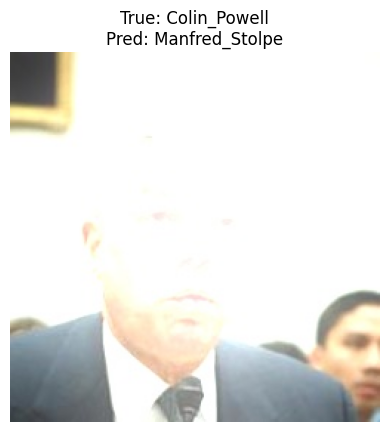

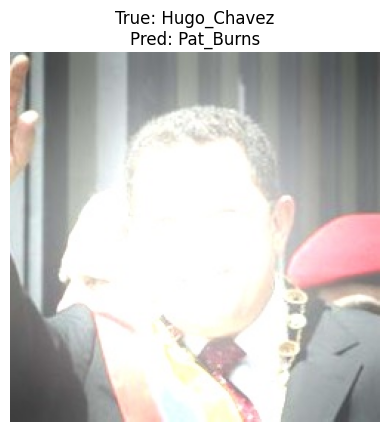

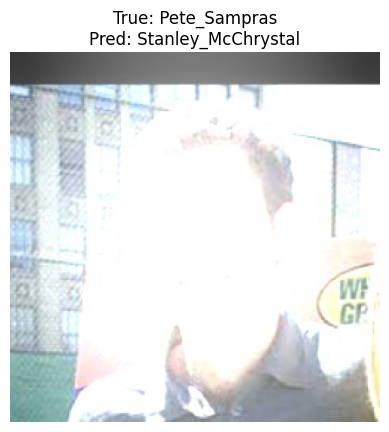

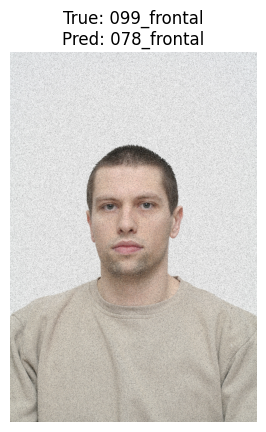

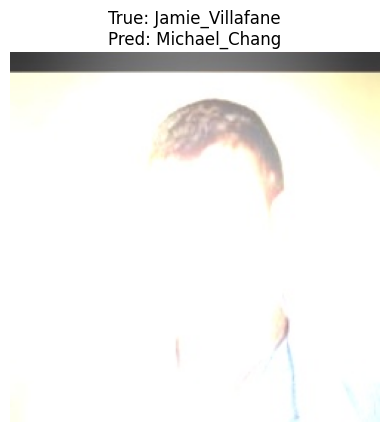

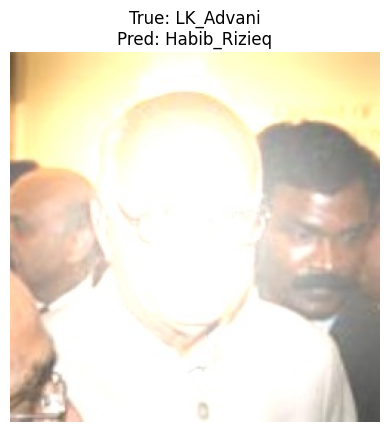

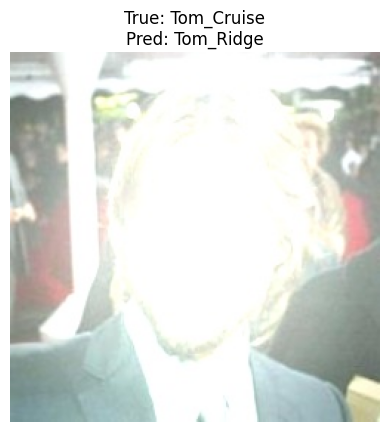

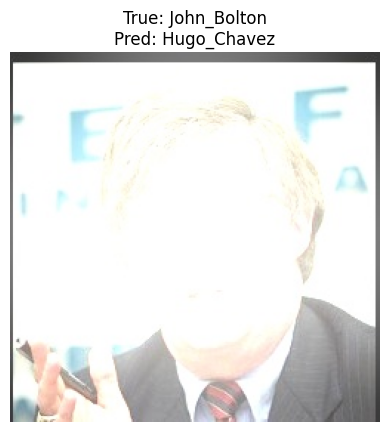

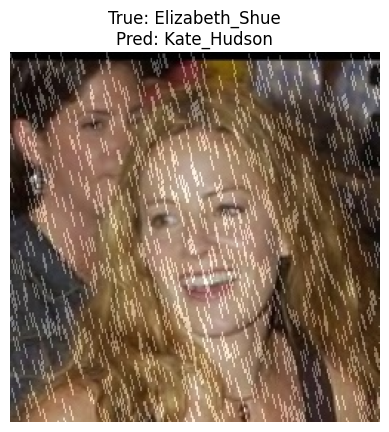

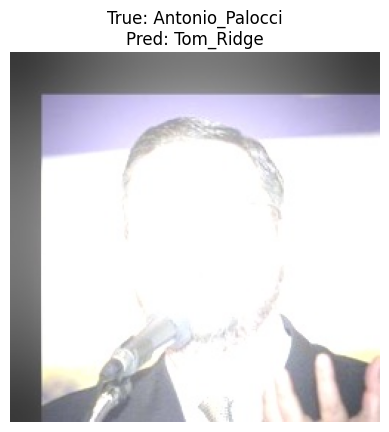

In [14]:

import matplotlib.pyplot as plt

mis_idx = np.where(pred_labels != true_labels)[0]
if len(mis_idx) > 0:
    print(f"Showing {min(10, len(mis_idx))} misclassified faces:")
    for i in range(min(10, len(mis_idx))):
        idx = mis_idx[i]
        img_path = test_df.iloc[idx]['image_path']
        img = tf.keras.utils.load_img(img_path)
        plt.imshow(img)
        plt.title(f"True: {le.inverse_transform([true_labels[idx]])[0]}\nPred: {le.inverse_transform([pred_labels[idx]])[0]}")
        plt.axis('off')
        plt.show()
else:
    print("🎉 No misclassified samples!")